In [6]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data

In [2]:
dataset_location = "C:/Users/thang/OneDrive/Desktop/school/DataChallenge/dataset_for_students/"

In [4]:
scene_df1 = pd.read_hdf(dataset_location+'scene.hdf5')
scene_df2 = pd.read_hdf(dataset_location+'scene2.hdf5')
scene_df3 = pd.read_hdf(dataset_location+'scene3.hdf5')
# car_scene_df1 = pd.read_hdf(dataset_location+'car_scene.hdf5')
# car_scene_df2 = pd.read_hdf(dataset_location+'car_scene2.hdf5')
# car_scene_df3 = pd.read_hdf(dataset_location+'car_scene3.hdf5')

In [5]:
calibration_df_1 = pd.read_hdf(dataset_location +'calibration_set_1.hdf5')
calibration_df_2 = pd.read_hdf(dataset_location +'calibration_set_2.hdf5')

# Challenge 1 and 2

In [7]:
def estimate_parameters(calibration_df):
    calibration_images = calibration_df['image'].values
    calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T
    
    # Ensure calibration_images is a numeric array
    calibration_images = np.array(calibration_images.tolist(), dtype=np.float32)
    calibration_temperatures = np.array(calibration_temperatures, dtype=np.float32)

    # Convert calibration images and temperatures to PyTorch tensors
    calibration_images_tensor = torch.tensor(calibration_images, dtype=torch.float32).to(device)
    calibration_temperatures_tensor = torch.tensor(calibration_temperatures, dtype=torch.float32).to(device)

    height, width = calibration_images_tensor.shape[1:]
    num_pixels = height * width

    # Reshape images for linear regression
    images_reshaped = calibration_images_tensor.view(calibration_images_tensor.shape[0], -1)
    calibration_temperatures_tensor = calibration_temperatures_tensor.to(device)

    # Add bias term for intercept in linear regression
    X = torch.cat([calibration_temperatures_tensor, torch.ones(calibration_temperatures_tensor.size(0), 1).to(device)], dim=1)

    # Perform linear regression using torch.linalg.lstsq
    responsivities_and_offsets = torch.linalg.lstsq(X, images_reshaped).solution

    # Separate responsivities and offsets
    responsivities = responsivities_and_offsets[:-1, :].T
    offsets = responsivities_and_offsets[-1, :]

    # Reshape back to original image shape
    offsets = offsets.view(height, width).to(device).numpy()
    responsivities = responsivities.view(height, width, -1).to(device).numpy()

    return offsets, responsivities


In [8]:
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    # Convert inputs to PyTorch tensors
    scene_image_tensor = torch.tensor(scene_image, dtype=torch.float32).to(device)
    offsets_tensor = torch.tensor(offsets, dtype=torch.float32).to(device)
    responsivities_tensor = torch.tensor(responsivities, dtype=torch.float32).to(device)
    scene_temp_tensor = torch.tensor(scene_temp, dtype=torch.float32).to(device)
    avg_black_body_temp_tensor = torch.tensor(avg_black_body_temp, dtype=torch.float32).to(device)

    height, width = scene_image_tensor.shape
    corrected_image_tensor = torch.zeros_like(scene_image_tensor)

    # Calculate expected value
    intercepts_tensor = offsets_tensor
    coef_fpa_tensor = responsivities_tensor[:, :, 0]
    coef_cn_tensor = responsivities_tensor[:, :, 1]
    expected_value = intercepts_tensor + coef_fpa_tensor * scene_temp_tensor + coef_cn_tensor * avg_black_body_temp_tensor
    
    # Apply correction
    corrected_image_tensor = scene_image_tensor - expected_value

    # Convert the result back to a numpy array if needed
    corrected_image = corrected_image_tensor.to(device).numpy()

    return corrected_image

In [9]:
def applier(calibration_df,scene_df):
    offset, gain = estimate_parameters(calibration_df)
    avg_black_body_temp = calibration_df['t_cn'].mean()
    # Process each scene image
    corrected_scene_images = []
    
    for index, row in scene_df.iterrows():
        scene_image = row['image']
        scene_temp = row['t_fpa']
        corrected_image = apply_correction(scene_image, offset, gain, scene_temp, avg_black_body_temp)
        corrected_scene_images.append(corrected_image)

    # Convert corrected_scene_images to numpy array
    return np.array(corrected_scene_images)

In [10]:
def display(scene_df, corrected_scene_images,index=15):
    plt.figure(figsize=(15, 5))

    # Original scene image
    plt.subplot(1, 2, 1)
    plt.title("Original Scene Image")
    plt.imshow(scene_df['image'][index], cmap='gray')

    # Denoised scene image
    plt.subplot(1, 2, 2)
    plt.title("Denoised Scene Image")
    plt.imshow(corrected_scene_images[index], cmap='gray')

    plt.show()

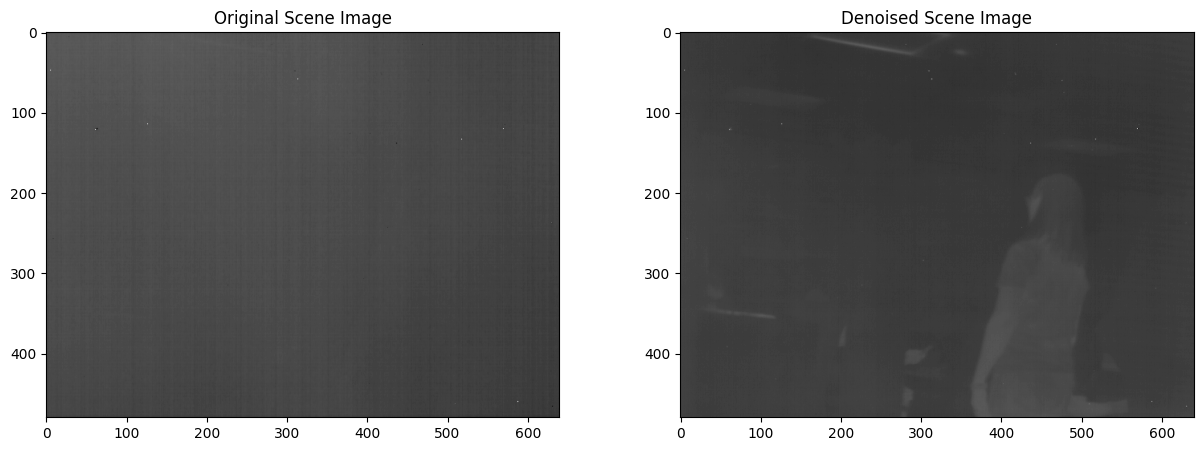

In [12]:
corrected_scene_images = applier(calibration_df_2,scene_df1)
display(scene_df1, corrected_scene_images,index=350)

# Challenge 3

In [28]:
def slice_array(arr, num=10):
    t, x, y = arr.shape
    
    # assert x % num == 0 and y % num == 0, "Dimensions x and y must be divisible by 10"
    
    slices = []
    for i in range(num):
        for j in range(num):
            slice_x_start = i * (x // num)
            slice_x_end = (i + 1) * (x // num)
            slice_y_start = j * (y // num)
            slice_y_end = (j + 1) * (y // num)
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append(slice_ij)
    
    return slices

def rebuild_array(slices, original_shape, num=10):
    x, y = original_shape
    rebuilt_array = torch.zeros((x, y), device=device)
    
    for idx, slice_ij in enumerate(slices):
        i = idx // num
        j = idx % num
        
        slice_x_start = i * (x // num)
        slice_x_end = (i + 1) * (x // num)
        slice_y_start = j * (y // num)
        slice_y_end = (j + 1) * (y // num)
        
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] = slice_ij
    
    return rebuilt_array

In [29]:
def sorted_uniform_pictures(arr):
    t, x, y = arr.shape
    variances = torch.var(arr, dim=(1, 2))
    sorted_indices = torch.argsort(variances)
    sorted_slices = arr[sorted_indices]
    return sorted_slices

def sorted_least_mean_pictures(arr):
    t, x, y = arr.shape
    means = torch.mean(arr, dim=(1, 2))
    sorted_indices = torch.argsort(means)
    sorted_slices = arr[sorted_indices]
    return sorted_slices

def pick_regular_slices(arr, num):
    t, x, y = arr.shape
    step = t // num
    indices = torch.arange(0, t, step, device=device)
    picked_slices = arr[indices]
    return picked_slices

def adjust_mean_to_target(arr, target_mean):
    current_mean = torch.mean(arr)
    difference = target_mean - current_mean
    adjusted_array = arr + difference
    return adjusted_array


In [30]:
def adjust_contrast(image, alpha, beta):
    adjusted_image = torch.clamp(alpha * image + beta, 0, 255).type(torch.uint8)
    return adjusted_image

In [31]:
def pseud_calibration(arr, num_slices, reg=100, adjust=None):
    slices = slice_array(arr, num_slices)
    _, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s) for s in slices]
    original_means = [torch.mean(s).item() for s in slices]
    
    print(medslice[0].shape)
    tenth = [pick_regular_slices(s, reg) for s in medslice]
    meaned = [torch.mean(t, dim=0) for t in tenth]
    
    if adjust is not None:
        adjusted = [adjust_mean_to_target(m, adjust) for m in meaned]
        meaned = adjusted
    
    return rebuild_array(meaned, (x, y), num_slices)

In [32]:
arr1 = torch.stack([torch.tensor(img, device=device) for img in scene_df1["image"].values])
filter_scene = pseud_calibration(arr1, 32)


corrected = arr1 - filter_scene
num = -100

torch.Size([400, 15, 20])


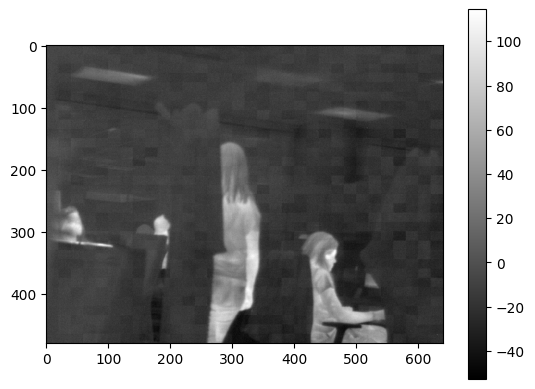

In [33]:
plt.imshow(corrected[-1], cmap='gray')
plt.colorbar()
plt.show()